# TemporalFusionTransformer with Simplified Feature Engineering

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Install requirements
#!pip3 install lightning pytorch_forecasting

In [7]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, QuantileLoss
from sklearn.preprocessing import StandardScaler
#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [15]:
#df = pd.read_csv('/content/drive/MyDrive/train.csv')

target_series = pd.read_csv('/content/drive/MyDrive/train_target_series.csv')
valid_series = pd.read_csv('/content/drive/MyDrive/valid_target_series.csv')

In [16]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)

    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"Decreased by {decrease:.2f}%")

    return df

scaler =  StandardScaler()
scaler.fit(target_series)

target_series.fillna(0, inplace=True)
target_series = reduce_mem_usage(target_series, verbose=1)
target_series = scaler.fit_transform(target_series)

valid_series.fillna(0, inplace=True)
valid_series = reduce_mem_usage(valid_series, verbose=1)
valid_series = scaler.transform(valid_series)

Memory usage of dataframe is 32.81 MB
Memory usage after optimization is: 8.20 MB
Decreased by 75.00%
Memory usage of dataframe is 7.55 MB
Memory usage after optimization is: 1.89 MB
Decreased by 75.00%


In [17]:
target_series = pd.DataFrame(target_series)
valid_series = pd.DataFrame(valid_series)

In [18]:
target_series.columns = target_series.columns.astype(str)
target_series.reset_index(level=0, inplace=True)
target_series.rename(columns={'index': 'time_step'}, inplace=True)
target_series["dummy_constant"] = 1
target_series.head()

,time_step,0,1,2,3,4,5,6,7,8,...,191,192,193,194,195,196,197,198,199,dummy_constant
0,0,-0.446533,-0.460938,-0.780762,-0.697266,-1.161133,0.509766,-0.277100,-0.248047,-0.662598,...,1.315430,-1.610352,-0.996094,0.431641,-0.054657,-0.126343,-0.983887,-0.007763,-0.019012,1
1,1,0.104309,-0.129272,-0.694336,-0.148315,-1.057617,0.580078,-0.473145,-0.956543,-0.070312,...,0.245850,-2.171875,-0.284668,-0.984863,-0.154785,-0.464844,-0.520020,-0.156494,-0.019012,1
2,2,0.721191,-0.541016,-0.593750,-0.331055,-0.069275,0.074829,0.320068,-1.432617,-0.451904,...,-0.735840,-1.772461,0.302734,-1.089844,0.992676,-0.018478,-0.797363,0.500488,-0.019012,1
3,3,0.919434,-0.429443,-0.541504,0.252930,-0.380859,-0.234131,0.059509,-0.827637,-0.105652,...,0.097168,-2.316406,0.592773,-1.018555,1.171875,0.199829,0.181152,0.567871,-0.019012,1
4,4,0.552246,-0.565918,-0.026077,-0.390137,-0.759277,-0.157349,0.239746,-0.160156,-0.335205,...,-0.162842,-1.292969,0.834473,-1.251953,0.770996,-0.200806,-0.235107,0.838379,-0.019012,1


In [19]:
valid_series.columns = valid_series.columns.astype(str)
valid_series.reset_index(level=0, inplace=True)
valid_series.rename(columns={'index': 'time_step'}, inplace=True)
valid_series["dummy_constant"] = 1
valid_series.head()

,time_step,0,1,2,3,4,5,6,7,8,...,191,192,193,194,195,196,197,198,199,dummy_constant
0,0,-0.435547,-0.692871,-0.033539,1.054688,1.708008,0.925293,0.205811,0.564941,1.051758,...,-1.108398,1.244141,-0.164429,-1.744141,-0.270752,-0.617188,0.662109,0.208008,-1.213867,1
1,1,0.612305,-0.023788,0.651367,0.420898,0.975586,1.265625,0.566895,2.351562,-0.333984,...,-0.714844,1.052734,0.038452,-2.644531,1.149414,-0.299072,0.271973,1.509766,-0.654785,1
2,2,1.074219,0.341309,1.335938,1.276367,0.734863,1.593750,1.060547,0.273438,-0.563965,...,-0.346436,0.781738,-0.270996,-1.550781,2.189453,0.027145,0.482422,1.394531,-1.093750,1
3,3,1.590820,0.361084,1.070312,1.501953,0.772461,1.035156,0.518066,0.081177,-0.569336,...,-0.005955,0.059662,-0.105835,-1.700195,1.471680,0.570312,0.229370,1.667969,-0.831055,1
4,4,1.399414,2.328125,1.062500,1.407227,0.401367,0.244263,0.491699,-0.389648,-0.515625,...,-0.597168,0.525391,-0.108826,-1.569336,0.737793,0.354736,-0.449219,1.734375,-0.624512,1


In [21]:
# Define the target columns
target_columns = [col for col in target_series.columns if col not in ["time_step", "dummy_constant"]]
#print(target_columns)

# Create a TimeSeriesDataSet
training = TimeSeriesDataSet(
    target_series,
    time_idx="time_step",
    target=target_columns,
    group_ids=["dummy_constant"],
    min_encoder_length=24,
    max_encoder_length=48,
    min_prediction_length=1,
    max_prediction_length=200,
    #time_varying_unknown_reals=target_columns,
    #time_varying_known_reals=["seconds_in_bucket"],
    allow_missing_timesteps=True,
    add_relative_time_idx = True,
)

validation = TimeSeriesDataSet.from_dataset(training, valid_series, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [22]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=64,
    attention_head_size=8,
    dropout=0.1,
    hidden_continuous_size=64,
    loss=QuantileLoss(),
    optimizer="Ranger",
    reduce_on_plateau_patience=10,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 347.5k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.03548133892335756
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.03548133892335756
INFO: Restoring states from the checkpoint path at /.lr_find_b3bd84c3-2f60-49a9-86aa-6074ffee82ca.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /.lr_find_b3bd84c3-2f60-49a9-86aa-6074ffee82ca.ckpt
INFO: Restored all states from the checkpoint at /.lr_find_b3bd84c3-2f60-49a9-86aa-6074ffee82ca.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /.lr_find_b3bd84c3-2f60-49a9-86aa-6074ffee82ca.ckpt


suggested learning rate: 0.03548133892335756


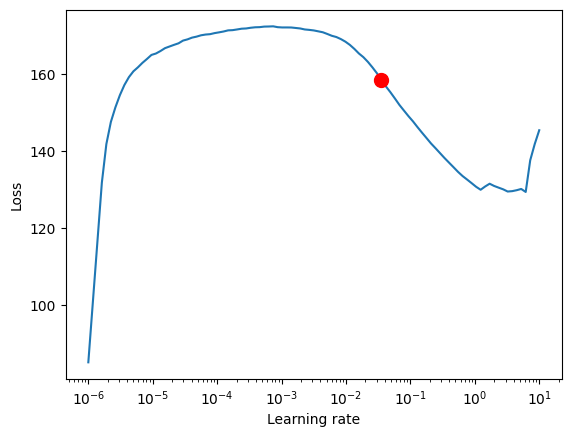

In [23]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [24]:
## configure network and trainer, already ran this
LEARNING_RATE = res.suggestion()

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    hidden_size=64,
    attention_head_size=8,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    #log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 301.8k


In [25]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 32    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initia

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
#print(len(predictions.y))

train_unscaled = pd.read_csv('/content/drive/MyDrive/train_target_series.csv')

#Initialize stanard scaler fit the scaler on trained data
scaler =  StandardScaler()
scaler.fit(train_unscaled)
trans_y = scaler.inverse_transform(predictions.y[0][0].cpu())
trans_out = scaler.inverse_transform(predictions.output[0][0].cpu().unsqueeze(0))

#Output the MAE of the prediction and outcome
mae = mean_absolute_error(trans_y, trans_out)

print("Mean Absolute Error:", mae)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Mean Absolute Error: 5.361680407155457
